25.10.30

In summary...

```python
## This works
element_dict = {
    v.element: xn_edges + xp_edges,
}

## This fails
element_dict = {
    v.element : xn_edges,
    v.element : xp_edges
}
```

Why?

Two issues. One is that we weren't creating seperate element objects. Two is that each element needs a different name.

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import torch as tc
import tensorflow as tf
import argparse
import pickle
import pandas as pd
from circuit_solver import circuit as ct
from circuit_solver import elements as es
from circuit_solver import utils
from circuit_solver.learning import CoupledLearning, CLTrainingConfig, CLTestingConfig

# Reproduce the bug

In [2]:
# data params
downsample_size = (5,5)
input_gain = 10.0
output_gain = 1.0

element = es.Resistor
k_min = 1E-1       # diode conductance
k_max = 1E1
element.param_ranges = [(k_min, k_max)]
element.init_mode = 'constant'
element.init_params = [k_min]
element_copy = es.Resistor

# Architecture params
N = downsample_size[0] * downsample_size[1] 
reverse_positives = False
reverse_negatives = False       # make the diodes between diodes and outputs point away from outputs

# training_config
batch_size = 50
eta = 0.5
alpha = 0.01
N_epochs = 1

training_config = CLTrainingConfig(
    batch_size=batch_size,
    N_epochs=N_epochs,
    eta=eta,
    alpha=alpha
)

absolute_high = max(input_gain, output_gain) 
model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
)

### Load and process data

In [3]:
# Training examples from the dataset. Initial shapes: x_train (P, 28, 28), y_train (P,)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Turn data into format that can be passed into circuit model
X_train, Y_train = utils.preprocess_MNIST_data(x_train, y_train, size=downsample_size, X_gain=input_gain, Y_gain=output_gain)
X_test, Y_test = utils.preprocess_MNIST_data(x_test, y_test, size=downsample_size, X_gain=input_gain, Y_gain=output_gain)

P_train, _ = X_train.shape
P_test, M = Y_test.shape

### Build circuit models

In [4]:
segment_sizes = (0, 0, 0, N, N, M)
N_nodes = sum(segment_sizes)
graph = nx.Graph()
graph.add_nodes_from(np.arange(N_nodes))

# define indices for different node types
GROUND, HIGH, LOW, xp_inds, xn_inds, y_inds = utils.segment_array(graph.nodes, segment_sizes)   # HIGH = [], LOW = []

x_inds = xp_inds + xn_inds
fixed_inds = GROUND + HIGH + LOW

# bipartite graph
xp_edges = utils.all_pairs_between(xp_inds, y_inds)
xn_edges = utils.all_pairs_between(xn_inds, y_inds)
fixed_edges = utils.all_pairs_between(fixed_inds, y_inds)
all_edges = xp_edges + xn_edges + fixed_edges
graph.add_edges_from(all_edges)

# check that graph is connected
if not nx.is_connected(graph):
    print('graph is not connected!')

element_dict_1 = {
    element : xp_edges + xn_edges,
}

element_dict_2 = {
    element : xn_edges,
    element_copy : xp_edges
}

circuit_1 = ct.Circuit(graph, element_dict_1)
circuit_2 = ct.Circuit(graph, element_dict_2)
# plt.subplots(dpi=300)
# plt.imshow(circuit_1.Del.toarray().T, cmap='bwr')

In [5]:
node_type_dict = {
    'GROUND': GROUND,
    'HIGH': HIGH,
    'LOW': LOW,
    'x': x_inds,
    'y': y_inds,
}

model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
    optimizer='adam'
)
model_1 = ct.CircuitModel(circuit_1, node_type_dict, model_config)
model_2 = ct.CircuitModel(circuit_2, node_type_dict, model_config)

In [6]:
x = tc.tensor(X_train[0][None])
y = tc.tensor(Y_train[0][None])

model_1.set_inputs(x_inds)
model_2.set_inputs(x_inds)

In [7]:
V_node_1, hist_1 = model_1(x)
V_node_2, hist_2 = model_2(x)

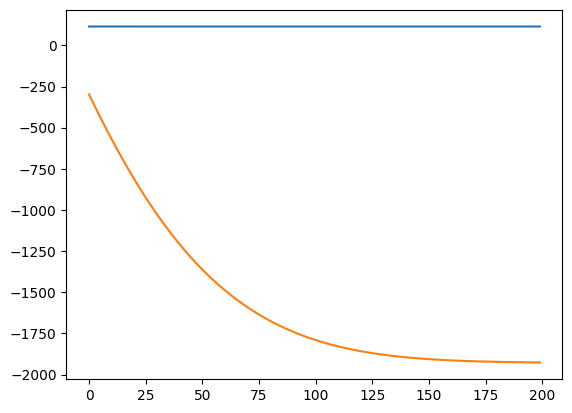

In [8]:
plt.plot(hist_1)
plt.plot(hist_2)

# The fix

There are actually two problems. First: element and element_copy are not different objects

In [9]:
element = es.Resistor
k_min = 1E-1       # diode conductance
k_max = 1E1
element.param_ranges = [(k_min, k_max)]
element.init_mode = 'constant'
element.init_params = [k_min]
element_copy = es.Resistor

In [10]:
element_copy is element

True

So the fix is

In [11]:
element = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor',param_ranges=[(1E-2, 1E2)])  
element_copy = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor',param_ranges=[(1E-2, 1E2)])
element is element_copy

False

The other issue is that elements need to have different names. If we don't do this there will only be one element_layer

In [12]:
element = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor',param_ranges=[(1E-2, 1E2)])  
element_copy = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor',param_ranges=[(1E-2, 1E2)])

element_dict_1 = {
    element : xp_edges + xn_edges,
}

element_dict_2 = {
    element : xn_edges,
    element_copy : xp_edges
}

circuit_1 = ct.Circuit(graph, element_dict_1)
circuit_2 = ct.Circuit(graph, element_dict_2)

node_type_dict = {
    'GROUND': GROUND,
    'HIGH': HIGH,
    'LOW': LOW,
    'x': x_inds,
    'y': y_inds,
}

model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
    optimizer='adam'
)
model_1 = ct.CircuitModel(circuit_1, node_type_dict, model_config)
model_2 = ct.CircuitModel(circuit_2, node_type_dict, model_config)

In [13]:
model_2.element_layers

{'Resistor': ElementLayer()}

So change the names

In [14]:
element = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor',param_ranges=[(1E-2, 1E2)])  
element_copy = es.ResistiveElement(es.rho_linear, N_params=1, name='Resistor_copy',param_ranges=[(1E-2, 1E2)])

element_dict_1 = {
    element : xp_edges + xn_edges,
}

element_dict_2 = {
    element : xn_edges,
    element_copy : xp_edges
}

circuit_1 = ct.Circuit(graph, element_dict_1)
circuit_2 = ct.Circuit(graph, element_dict_2)

node_type_dict = {
    'GROUND': GROUND,
    'HIGH': HIGH,
    'LOW': LOW,
    'x': x_inds,
    'y': y_inds,
}

model_config = ct.CircuitModelConfig(
    HIGH_voltage=absolute_high,
    LOW_voltage=-absolute_high,
    optimizer='adam'
)
model_1 = ct.CircuitModel(circuit_1, node_type_dict, model_config)
model_2 = ct.CircuitModel(circuit_2, node_type_dict, model_config)

In [15]:
x = tc.tensor(X_train[0][None])
y = tc.tensor(Y_train[0][None])

model_1.set_inputs(x_inds)
model_2.set_inputs(x_inds)

In [16]:
V_node_1, hist_1 = model_1(x)
V_node_2, hist_2 = model_2(x)

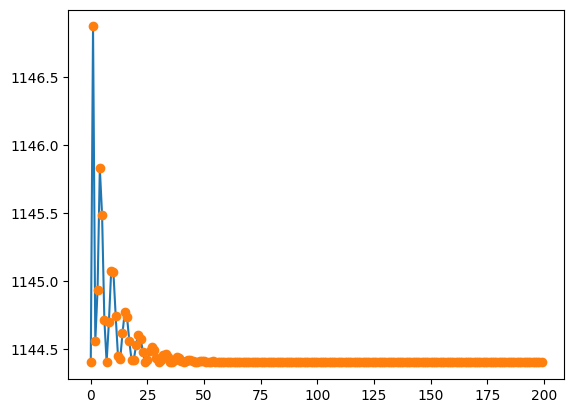

In [17]:
plt.plot(hist_1)
plt.plot(hist_2, 'o')